Necessary Libraries are imported

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from keras.preprocessing import text, sequence
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from scipy import spatial
from sklearn.manifold import TSNE
from numpy.random import seed
import gensim
from gensim.utils import simple_preprocess 
from gensim.parsing.preprocessing import STOPWORDS
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
seed(1)

# Two Input


## Data Input

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df_fake = pd.read_csv("/content/drive/MyDrive/ST456_Final_Data/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/ST456_Final_Data/True.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning

Word tokenization and simplification process

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Function is defined to simplify text using stopwords and filtering out words less than length 3.

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(STOPWORDS) # conbime two stopwords packages together

def preprocess(text):
    result = []
    for token in simple_preprocess(text): # simplify the word text
        if len(token) > 3 and token not in stop_words: # only consider the word with length more than 3 and not in stopwords list
            result.append(token)
    return result

In [5]:
# Apply preprocessing function to data
df_true_title = df_true['title'].apply(preprocess)
df_fake_title = df_fake['title'].apply(preprocess)
df_true_text = df_true['text'].apply(preprocess)
df_fake_text = df_fake['text'].apply(preprocess)

Next, the tokenization process is carried out. Each title/text section is tokenized.

In [6]:
#lower=False separates capital and lowerase letters
tokenizer = Tokenizer(lower=False)

title_X = pd.concat([df_true_title, df_fake_title], axis = 0)
title_Y = np.concatenate((np.ones([len(df_true_title), 1]), np.zeros([len(df_fake_title), 1])), axis = 0)
X_train, X_test, Y_train, Y_test = train_test_split(title_X, title_Y, test_size=0.2, random_state=42)

text1 = list(X_train)
tokenizer.fit_on_texts(text1)
pad_seq1 = pad_sequences(tokenizer.texts_to_sequences(text1), maxlen = 20,  padding='post', value=0)
x_train_title = tf.convert_to_tensor(pad_seq1)
y_train_title = tf.convert_to_tensor(Y_train)


text2 = list(X_test)
tokenizer.fit_on_texts(text2)
pad_seq2 = pad_sequences(tokenizer.texts_to_sequences(text2),maxlen = 20, padding='post', value=0)
x_test_title = tf.convert_to_tensor(pad_seq2)
y_test_title = tf.convert_to_tensor(Y_test)


text_X = pd.concat([df_true_text, df_fake_text], axis = 0)
text_Y = np.concatenate((np.ones([len(df_true_text), 1]), np.zeros([len(df_fake_text), 1])), axis = 0)
X_train, X_test, Y_train, Y_test = train_test_split(text_X, text_Y, test_size=0.2, random_state=42)


text3 = list(X_train)
tokenizer.fit_on_texts(text3)
pad_seq3 = pad_sequences(tokenizer.texts_to_sequences(text3), maxlen = 200, padding='post', value=0)
x_train_text = tf.convert_to_tensor(pad_seq3)
y_train_text = tf.convert_to_tensor(Y_train)

text4 = list(X_test)
tokenizer.fit_on_texts(text4)
pad_seq4 = pad_sequences(tokenizer.texts_to_sequences(text2), maxlen = 200, padding='post', value=0)
x_test_text = tf.convert_to_tensor(pad_seq4)
y_test_text = tf.convert_to_tensor(Y_test)

6B GLoVE Pre-embeddings are downloaded from website https://nlp.stanford.edu/projects/glove/, and the file "glove.6B.100d.txt" is uploaded to the Colab Environment.

In [7]:
emb_dictionary = {}
#Creates dictionary to store word vectors from GLoVe file
with open("glove.6B.100d.txt", 'r') as glove:
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        emb_dictionary[word] = vector

In [8]:
# Define number of words
vocab_size = len(tokenizer.word_index) + 1  # add 1 for the padding token
# since 100d.txt
embedding_dim = 100

# Create embedding matrix to use in NN 
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    embedding_vector = emb_dictionary.get(word)
    if embedding_vector is not None and len(embedding_vector) == embedding_dim:
        embedding_matrix[i] = embedding_vector


## CNN Model

In [49]:
# Define input lengths for titles and texts
max_len1 = 20
max_len2 = 200
vocab_size1 = 20000 
embedding_dim1 = 100
vocab_size2 = 110000 
embedding_dim2 = 200
embedding_dim = 100
num_filters = 128
filter_size = 3
pool_size = 4
dropout_rate = 0.5


# Title input
title_input = tf.keras.Input(shape=(max_len1,))
title_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(title_input)
title_conv_1 = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(title_embed)
title_conv_2 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(title_embed)
title_conv_3 = tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu')(title_embed)

title_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_1)
title_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_2)
title_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_3)

# Resize the inputs to have the same shape
title_pool_1 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_1)
title_pool_2 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_2)
title_pool_3 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_3)

title_merged = tf.keras.layers.concatenate([title_pool_1, title_pool_2, title_pool_3])
title_merged = tf.keras.layers.Reshape((1, -1))(title_merged) 

title_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_merged)
title_pool = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv)

title_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_pool)
title_pool1 = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv1)

title_global_pool = tf.keras.layers.GlobalMaxPooling1D()(title_pool1)
title_drop = tf.keras.layers.Dropout(dropout_rate)(title_global_pool)

# Text input
text_input = tf.keras.Input(shape=(max_len2,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(text_input)

text_conv_1 = tf.keras.layers.Conv1D(5, 8, padding='same', activation='relu')(text_embed)
text_conv_2 = tf.keras.layers.Conv1D(4, 8, padding='same', activation='relu')(text_embed)
text_conv_3 = tf.keras.layers.Conv1D(3, 4, padding='same', activation='relu')(text_embed)

text_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_1)
text_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_2)
text_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_3)

text_merged = tf.keras.layers.concatenate([text_pool_1, text_pool_2, text_pool_3])

text_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_merged)
text_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv)

text_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_pool)
text_pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv1)

text_global_pool = tf.keras.layers.GlobalMaxPooling1D()(text_pool1)
text_drop = tf.keras.layers.Dropout(dropout_rate)(text_global_pool)

# Concatenate title and text
merged = tf.keras.layers.concatenate([title_drop, text_drop])


merged_dense = tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)



model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
model_cnn.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 20, 100)      10870600    ['input_7[0][0]']                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 20, 32)       12832       ['embedding_6[0][0]']            
                                                                                                  
 conv1d_17 (Conv1D)             (None, 20, 64)       51264       ['embedding_6[0][0]']            
                                                                                            

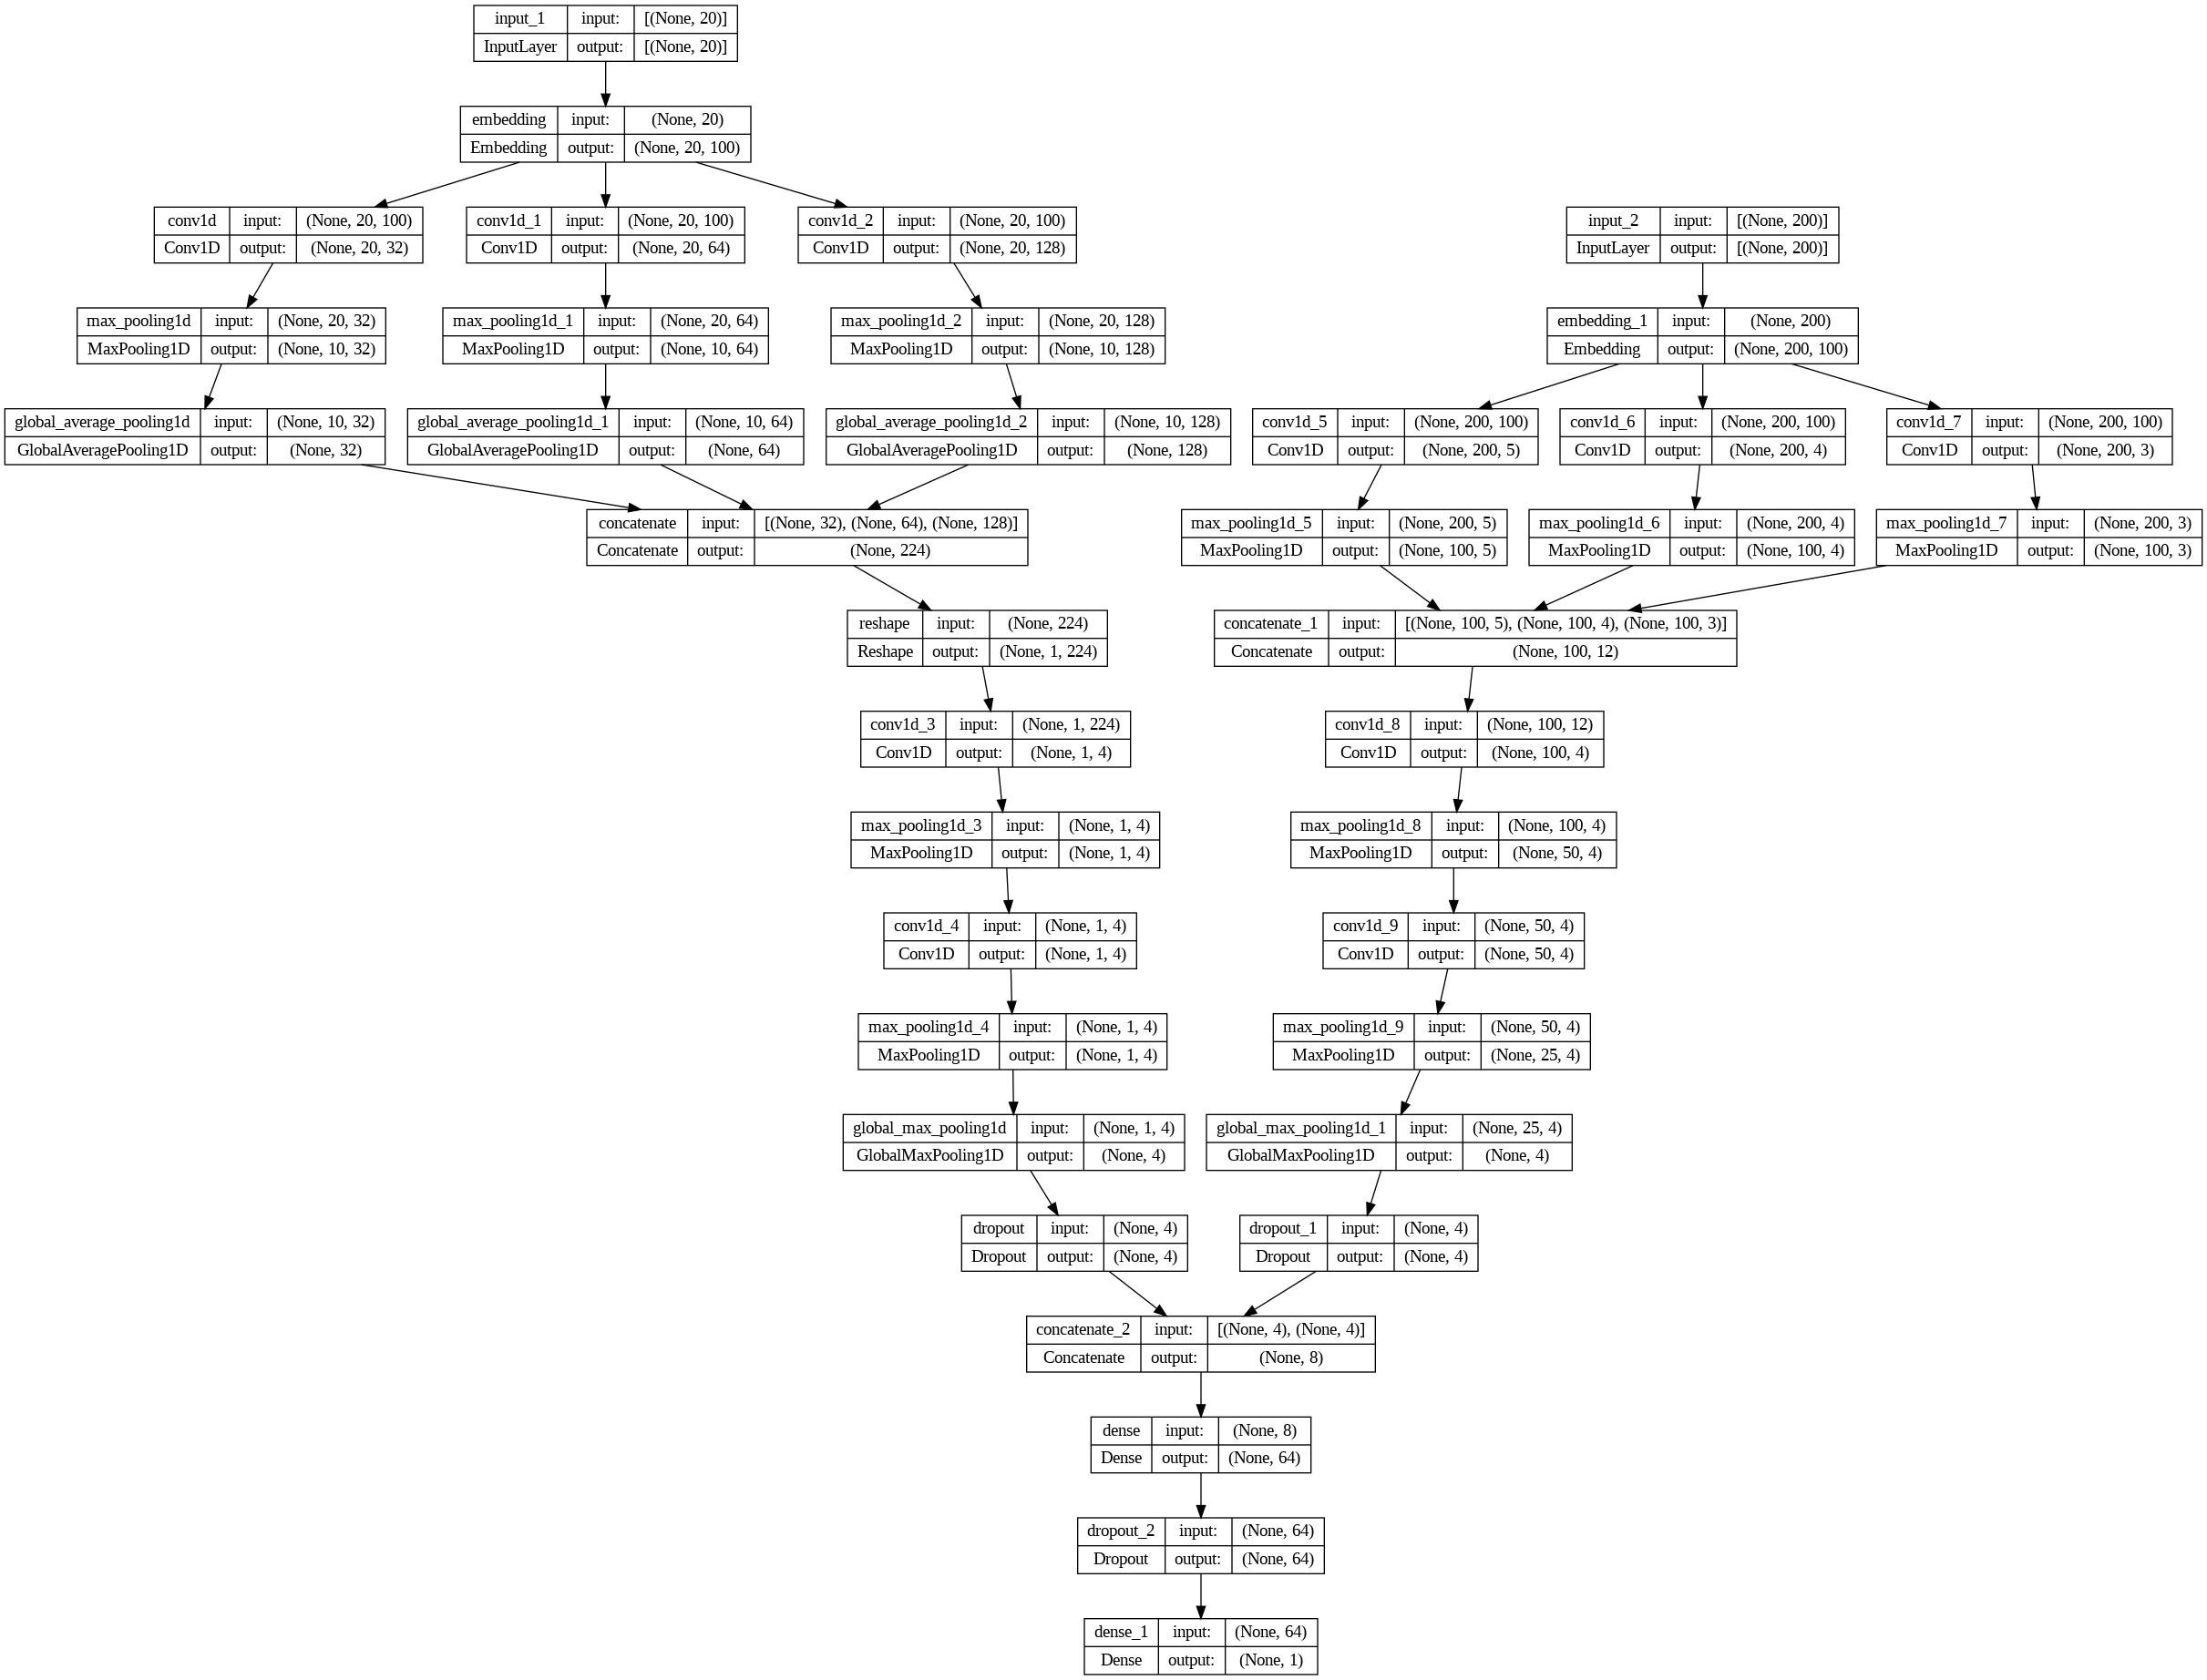

In [10]:
tf.keras.utils.plot_model(model_cnn, show_shapes=True)

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

# create model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# define early stopping regulariser
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history_cnn= model_cnn.fit([x_train_title, x_train_text], y_train_text, validation_split = 0.2, epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
113/113 [==============================] - 10s 24ms/step - loss: 0.8445 - accuracy: 0.5195 - val_loss: 0.8236 - val_accuracy: 0.5902
Epoch 2/100
113/113 [==============================] - 2s 18ms/step - loss: 0.8168 - accuracy: 0.5555 - val_loss: 0.8013 - val_accuracy: 0.7233
Epoch 3/100
113/113 [==============================] - 2s 17ms/step - loss: 0.7929 - accuracy: 0.6116 - val_loss: 0.7692 - val_accuracy: 0.7585
Epoch 4/100
113/113 [==============================] - 2s 16ms/step - loss: 0.7598 - accuracy: 0.6721 - val_loss: 0.7239 - val_accuracy: 0.7698
Epoch 5/100
113/113 [==============================] - 2s 21ms/step - loss: 0.7218 - accuracy: 0.7151 - val_loss: 0.6754 - val_accuracy: 0.7829
Epoch 6/100
113/113 [==============================] - 2s 21ms/step - loss: 0.6793 - accuracy: 0.7427 - val_loss: 0.6122 - val_accuracy: 0.8217
Epoch 7/100
113/113 [==============================] - 2s 17ms/step - loss: 0.6195 - accuracy: 0.7710 - val_loss: 0.5249 - val_accuracy

In [51]:
print("The accuracy of the 2-input CNN model on the test data is - " , model_cnn.evaluate([x_test_title, x_test_text], y_test_text)[1]*100 , "%")

281/281 [==============================] - 1s 5ms/step - loss: 0.6637 - accuracy: 0.7800
The accuracy of the 2-input CNN model on the test data is -  77.99554467201233 %


In [13]:
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']
acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

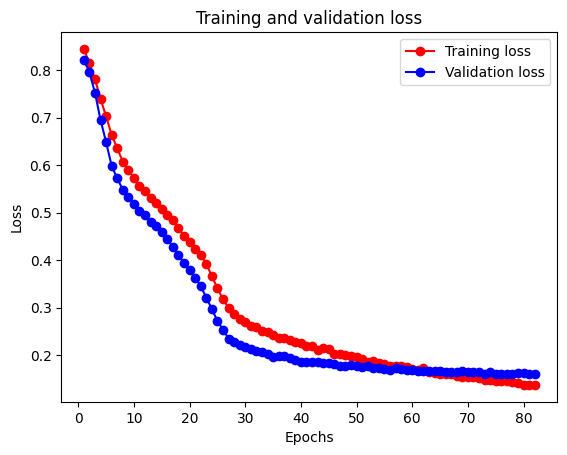

In [14]:
epochs = range(1, len(loss_cnn)+1)
plt.clf()
plt.plot(epochs, loss_cnn, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_cnn, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

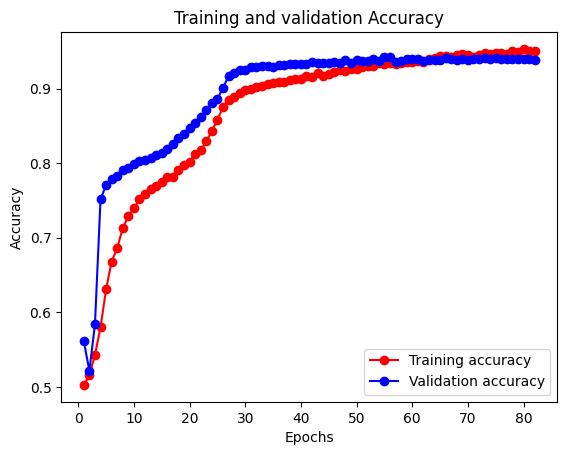

In [15]:
epochs = range(1, len(loss_cnn)+1)
plt.clf()
plt.plot(epochs, acc_cnn, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_cnn, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
y_pred_text = model_cnn.predict([x_test_title, x_test_text])
y_pred_text = [1 if x > 0.5 else 0 for x in y_pred_text]
accuracy = accuracy_score(y_test_text, y_pred_text)
precision = precision_score(y_test_text, y_pred_text, average='macro')
recall = recall_score(y_test_text, y_pred_text, average='macro')
f1 = f1_score(y_test_text, y_pred_text, average='macro')
confusion = confusion_matrix(y_test_text, y_pred_text)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 1s 3ms/step
Accuracy: 0.6560133630289532
Precision: 0.7004504811135313
Recall: 0.6469817974124016
F1 score: 0.6275370438857083
Confusion matrix:
 [[4187  463]
 [2626 1704]]


## RNN Model

In [17]:
max_len1 = 20
max_len2 = 200
vocab_size1 = 108706
embedding_dim1 = 100
vocab_size2 = 108706
embedding_dim2 = 100
embedding_dim = 100
num_filters = 128
pool_size = 8
dropout_rate = 0.5
rnn_units = 64

# title input
title_input = tf.keras.Input(shape=(max_len1,))
title_embed = tf.keras.layers.Embedding(vocab_size1, embedding_dim1, weights=[embedding_matrix], input_length=max_len2)(title_input)
title_rnn = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(title_embed)
title_rnn = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_rnn)
title_rnn = tf.keras.layers.LSTM(rnn_units, return_sequences = True)(title_rnn)
title_rnn = tf.keras.layers.LSTM(rnn_units)(title_rnn)


# text input
text_input = tf.keras.Input(shape=(max_len2,))
text_embed = tf.keras.layers.Embedding(vocab_size2, embedding_dim2,weights=[embedding_matrix], input_length=max_len2)(text_input)
text_rnn = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(text_embed)
text_rnn = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(text_rnn)
text_rnn = tf.keras.layers.LSTM(rnn_units, return_sequences = True)(text_rnn)
text_rnn = tf.keras.layers.LSTM(rnn_units)(text_rnn)

# Concatenate title and text
merged = tf.keras.layers.concatenate([title_rnn, text_rnn])

merged_dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)

# Create model
model_rnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
model_rnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 20, 100)      10870600    ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 100)     10870600    ['input_4[0][0]']                
                                                                                            

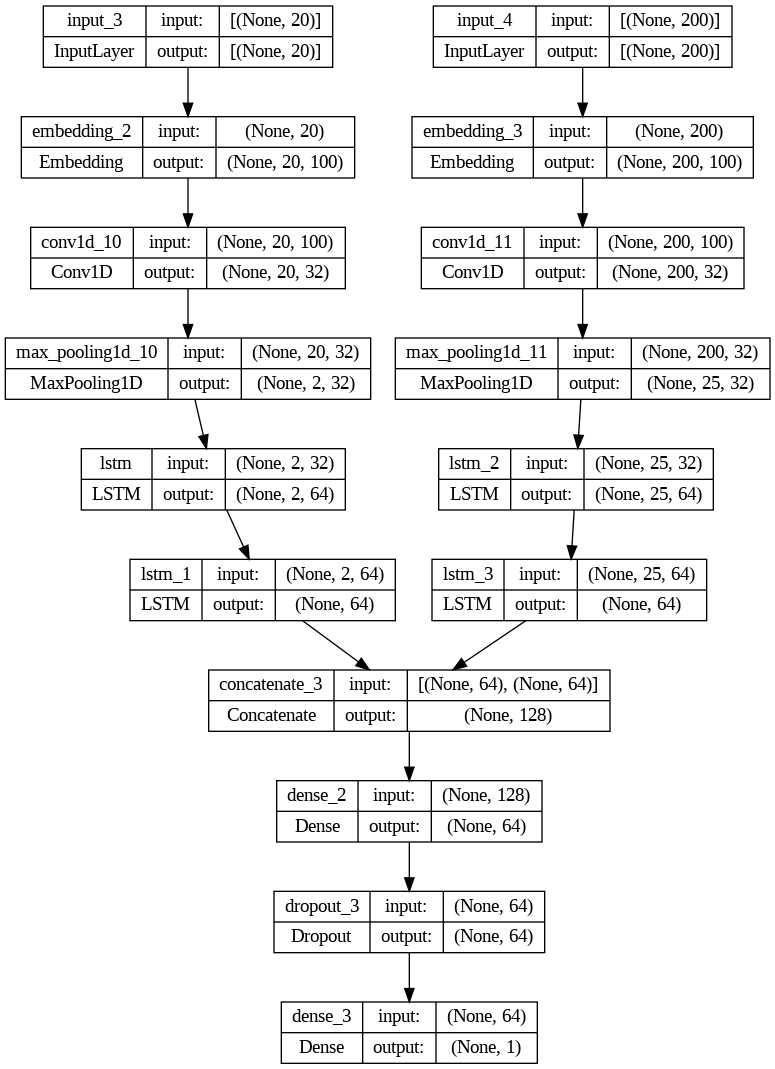

In [18]:
tf.keras.utils.plot_model(model_rnn, show_shapes=True)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Create model
model_rnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model_rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_rnn= model_rnn.fit([x_train_title, x_train_text], y_train_text, validation_split = 0.2, epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
113/113 [==============================] - 60s 393ms/step - loss: 1.4567 - accuracy: 0.5833 - val_loss: 1.3211 - val_accuracy: 0.7494
Epoch 2/100
113/113 [==============================] - 30s 262ms/step - loss: 1.1058 - accuracy: 0.8293 - val_loss: 0.9011 - val_accuracy: 0.8891
Epoch 3/100
113/113 [==============================] - 21s 186ms/step - loss: 0.8089 - accuracy: 0.9110 - val_loss: 0.7350 - val_accuracy: 0.9099
Epoch 4/100
113/113 [==============================] - 18s 165ms/step - loss: 0.6502 - accuracy: 0.9376 - val_loss: 0.5954 - val_accuracy: 0.9400
Epoch 5/100
113/113 [==============================] - 19s 165ms/step - loss: 0.5351 - accuracy: 0.9548 - val_loss: 0.5113 - val_accuracy: 0.9478
Epoch 6/100
113/113 [==============================] - 16s 143ms/step - loss: 0.4439 - accuracy: 0.9664 - val_loss: 0.4328 - val_accuracy: 0.9539
Epoch 7/100
113/113 [==============================] - 12s 102ms/step - loss: 0.3661 - accuracy: 0.9751 - val_loss: 0.3770 -

In [20]:
print("The accuracy of the 2-input RNN model on the test data is - " , model_rnn.evaluate([x_test_title, x_test_text], y_test_text)[1]*100 , "%")

281/281 [==============================] - 2s 8ms/step - loss: 2.3945 - accuracy: 0.5160
The accuracy of the 2-input RNN model on the test data is -  51.60356163978577 %


In [21]:
loss_rnn = history_rnn.history['loss']
val_loss_rnn = history_rnn.history['val_loss']
acc_rnn = history_rnn.history['accuracy']
val_acc_rnn = history_rnn.history['val_accuracy']

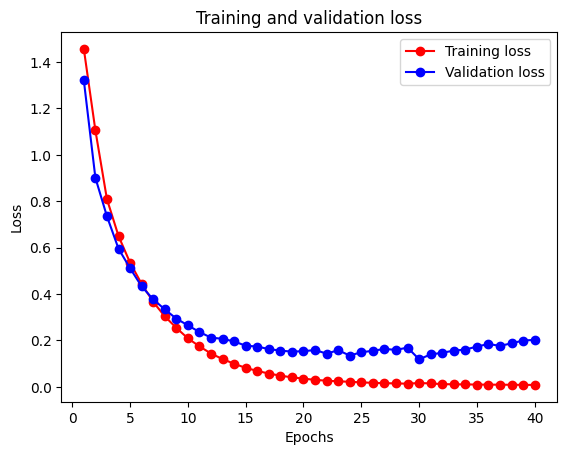

In [22]:
epochs = range(1, len(loss_rnn)+1)
plt.clf()
plt.plot(epochs, loss_rnn, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_rnn, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

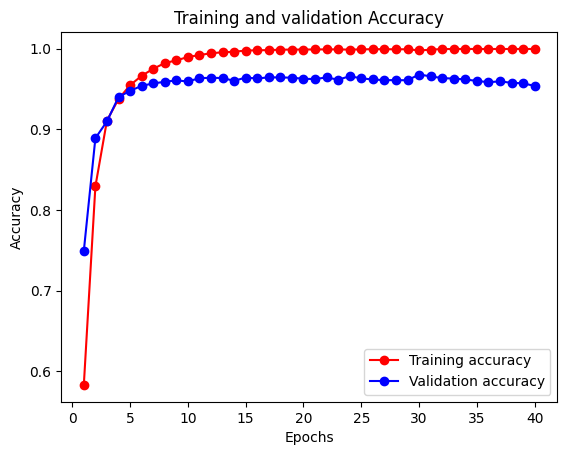

In [23]:
epochs = range(1, len(loss_rnn)+1)
plt.clf()
plt.plot(epochs, acc_rnn, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_rnn, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
y_pred_text = model_rnn.predict([x_test_title, x_test_text])
y_pred_text = [1 if x > 0.5 else 0 for x in y_pred_text]
accuracy = accuracy_score(y_test_text, y_pred_text)
precision = precision_score(y_test_text, y_pred_text, average='macro')
recall = recall_score(y_test_text, y_pred_text, average='macro')
f1 = f1_score(y_test_text, y_pred_text, average='macro')
confusion = confusion_matrix(y_test_text, y_pred_text)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 3s 4ms/step
Accuracy: 0.5160356347438753
Precision: 0.4864141414141414
Recall: 0.4989311877622985
F1 score: 0.35662047989185536
Confusion matrix:
 [[4552   98]
 [4248   82]]


# One Input CNN


The single input data is created and pre-processed using the same techniques as for the separated data.

In [25]:
#binary variable is created to indicate real\fake
df_true['is_True'] = 1
df_fake['is_True'] = 0

# fake/real datasets joined
data = pd.concat([df_fake, df_true], ignore_index=True)

#text/title combined and title and subject removed from data
data['text'] = data['title']+ " " +  data['text'] 
del data['title']
del data['subject']

In [26]:
data['text'] = data['text'].apply(preprocess)

## GLoVE embeddings


In [27]:
#Tokenizer for combined title/text
tokenizer = Tokenizer(lower=False)
text_X = data['text']
text_Y = data['is_True'].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(text_X, text_Y, test_size=0.2, random_state=42)


text1 = list(X_train)
tokenizer.fit_on_texts(text1)
pad_seq1 = pad_sequences(tokenizer.texts_to_sequences(text1), maxlen = 300,  padding='post', value=0)
x_train = tf.convert_to_tensor(pad_seq1)
y_train = tf.convert_to_tensor(Y_train)

text2 = list(X_test)
tokenizer.fit_on_texts(text2)
pad_seq2 = pad_sequences(tokenizer.texts_to_sequences(text2),maxlen = 300, padding='post', value=0)
x_test = tf.convert_to_tensor(pad_seq2)
y_test = tf.convert_to_tensor(Y_test)

6B GLoVE Pre-embeddings are downloaded from website https://nlp.stanford.edu/projects/glove/, and the file "glove.6B.100d.txt" is uploaded to the Colab Environment.

In [28]:
emb_dictionary = {}
#Creates dictionary to store word vectors from GLoVe file
with open("glove.6B.100d.txt", 'r') as glove:
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        emb_dictionary[word] = vector

In [29]:
# Define number of words
vocab_size = len(tokenizer.word_index) + 1  # add 1 for the padding token
# since 100d.txt
embedding_dim = 100

# Create embedding matrix to use in NN 
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    embedding_vector = emb_dictionary.get(word)
    if embedding_vector is not None and len(embedding_vector) == embedding_dim:
        embedding_matrix[i] = embedding_vector

## CNN Model

In [30]:
import tensorflow as tf

max_len = 300
embedding_dim = 100
num_filters = 128
filter_size = 3
pool_size = 4
dropout_rate = 0.5

# Input for texts
text_input = tf.keras.Input(shape=(max_len,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(text_input)

text_conv_1 = tf.keras.layers.Conv1D(num_filters, filter_size, padding='same')(text_embed)
text_conv_1 = tf.keras.layers.LeakyReLU()(text_conv_1)

text_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(text_conv_1)

text_conv_2 = tf.keras.layers.Conv1D(num_filters, filter_size, padding='same')(text_pool_1)
text_conv_2 = tf.keras.layers.LeakyReLU()(text_conv_2)

text_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(text_conv_2)

text_conv_3 = tf.keras.layers.Conv1D(num_filters, filter_size, padding='same')(text_pool_2)
text_conv_3 = tf.keras.layers.LeakyReLU()(text_conv_3)

text_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=pool_size, padding='same')(text_conv_3)

text_global_pool = tf.keras.layers.GlobalMaxPooling1D()(text_pool_3)
text_drop = tf.keras.layers.Dropout(dropout_rate)(text_global_pool)


dense1 = tf.keras.layers.Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(text_drop)
batch_norm = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(32, activation='relu')(batch_norm)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(dense2)


output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)
model_cnn1 = tf.keras.Model(inputs=text_input, outputs=output)

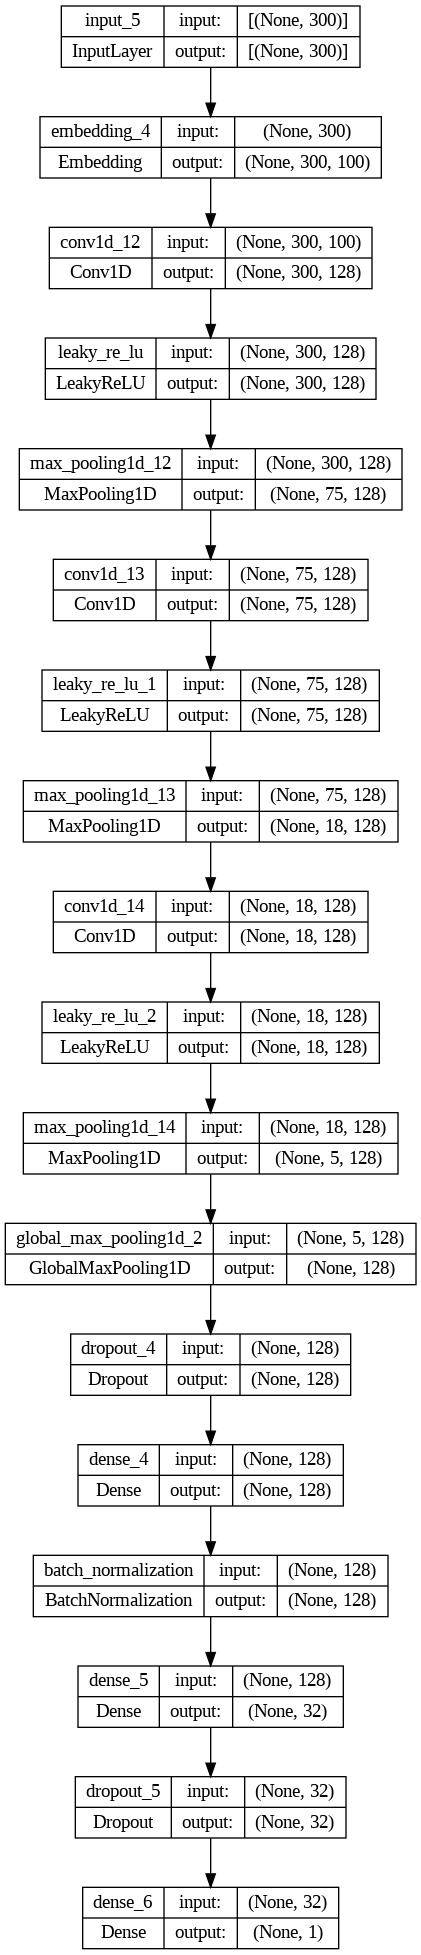

In [31]:
tf.keras.utils.plot_model(model_cnn1, show_shapes=True)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
# Create model
model_cnn1 = tf.keras.Model(inputs=text_input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model_cnn1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history_cnn1 = model_cnn1.fit(x_train, Y_train, validation_split=0.2, epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
113/113 [==============================] - 7s 28ms/step - loss: 2.1915 - accuracy: 0.5241 - val_loss: 1.8337 - val_accuracy: 0.5398
Epoch 2/100
113/113 [==============================] - 2s 20ms/step - loss: 1.8739 - accuracy: 0.5828 - val_loss: 1.6424 - val_accuracy: 0.7652
Epoch 3/100
113/113 [==============================] - 2s 18ms/step - loss: 1.5478 - accuracy: 0.7328 - val_loss: 1.4007 - val_accuracy: 0.8576
Epoch 4/100
113/113 [==============================] - 2s 18ms/step - loss: 1.2767 - accuracy: 0.8391 - val_loss: 1.1424 - val_accuracy: 0.9205
Epoch 5/100
113/113 [==============================] - 2s 18ms/step - loss: 1.0678 - accuracy: 0.9025 - val_loss: 0.9595 - val_accuracy: 0.9435
Epoch 6/100
113/113 [==============================] - 2s 19ms/step - loss: 0.9270 - accuracy: 0.9316 - val_loss: 0.8337 - val_accuracy: 0.9542
Epoch 7/100
113/113 [==============================] - 2s 20ms/step - loss: 0.8239 - accuracy: 0.9433 - val_loss: 0.7416 - val_accuracy:

In [33]:
print("The accuracy of the CNN model on test data is - " , model_cnn1.evaluate(x_test, y_test)[1]*100 , "%")

281/281 [==============================] - 1s 4ms/step - loss: 0.1655 - accuracy: 0.9699
The accuracy of the CNN model on test data is -  96.99332118034363 %


In [34]:
loss_cnn1 = history_cnn1.history['loss']
val_loss_cnn1 = history_cnn1.history['val_loss']
acc_cnn1 = history_cnn1.history['accuracy']
val_acc_cnn1 = history_cnn1.history['val_accuracy']

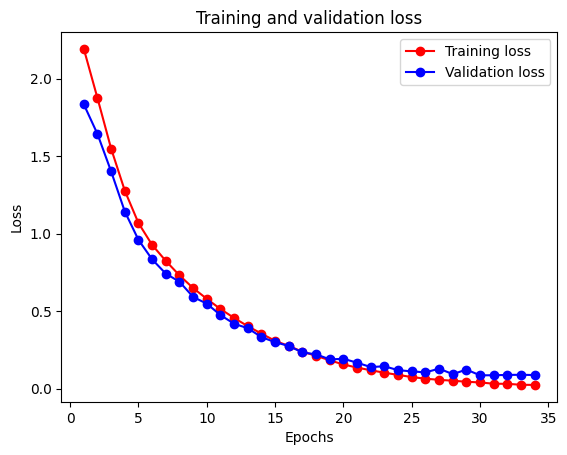

In [35]:
epochs = range(1, len(loss_cnn1)+1)
plt.clf()
plt.plot(epochs, loss_cnn1, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_cnn1, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

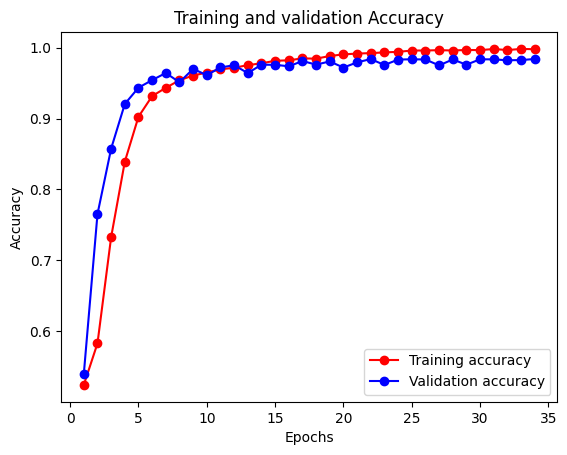

In [36]:
epochs = range(1, len(loss_cnn1)+1)
plt.clf()
plt.plot(epochs, acc_cnn1, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_cnn1, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
y_pred = model_cnn1.predict(x_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
confusion = confusion_matrix(Y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 1s 2ms/step
Accuracy: 0.9699331848552338
Precision: 0.9695440469171812
Recall: 0.9704976620376715
F1 score: 0.9698798159187918
Confusion matrix:
 [[4544  189]
 [  81 4166]]


# One Input RNN


In [38]:
# Define input lengths for titles and texts
max_len = 300
embedding_dim = 100
num_filters = 128
filter_size = 8
pool_size = 8
dropout_rate = 0.5
rnn_units = 64


# Input for texts
text_input = tf.keras.Input(shape=(max_len,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix], input_length=max_len)(text_input)
text_rnn = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(text_embed)
text_rnn = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(text_rnn)
text_rnn = tf.keras.layers.LSTM(rnn_units, return_sequences = True)(text_rnn)
text_rnn = tf.keras.layers.LSTM(rnn_units)(text_rnn)

merged_dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(text_rnn)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)
model_rnn1 = tf.keras.Model(inputs=text_input, outputs=output)

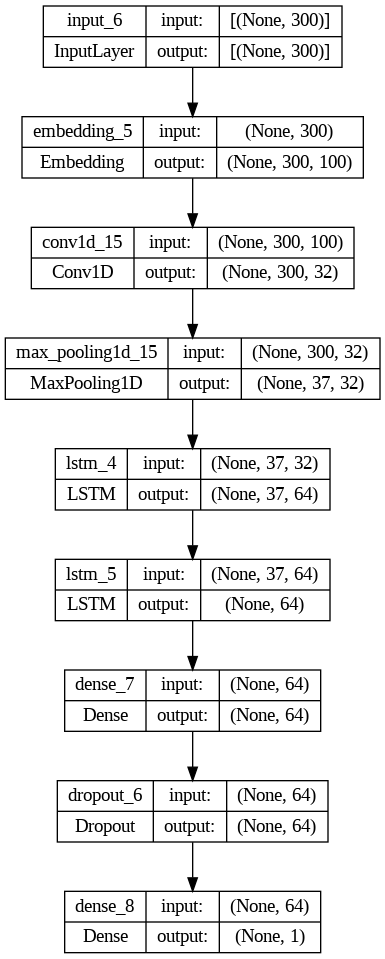

In [39]:
tf.keras.utils.plot_model(model_rnn1, show_shapes=True)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

# Create model
model_rnn1 = tf.keras.Model(inputs=text_input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model_rnn1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history_rnn1 = model_rnn1.fit(x_train, Y_train, validation_split=0.2, epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
113/113 [==============================] - 34s 250ms/step - loss: 1.2849 - accuracy: 0.5519 - val_loss: 1.1955 - val_accuracy: 0.6247
Epoch 2/100
113/113 [==============================] - 23s 207ms/step - loss: 1.0122 - accuracy: 0.7780 - val_loss: 0.8093 - val_accuracy: 0.8767
Epoch 3/100
113/113 [==============================] - 20s 180ms/step - loss: 0.7378 - accuracy: 0.8996 - val_loss: 0.6538 - val_accuracy: 0.9123
Epoch 4/100
113/113 [==============================] - 18s 161ms/step - loss: 0.5935 - accuracy: 0.9364 - val_loss: 0.5442 - val_accuracy: 0.9357
Epoch 5/100
113/113 [==============================] - 17s 148ms/step - loss: 0.4912 - accuracy: 0.9546 - val_loss: 0.4502 - val_accuracy: 0.9548
Epoch 6/100
113/113 [==============================] - 15s 131ms/step - loss: 0.4025 - accuracy: 0.9721 - val_loss: 0.3832 - val_accuracy: 0.9651
Epoch 7/100
113/113 [==============================] - 12s 104ms/step - loss: 0.3426 - accuracy: 0.9786 - val_loss: 0.3315 -

In [41]:
print("The accuracy of the model on the test data is - " , model_rnn1.evaluate(x_test, y_test)[1]*100 , "%")

281/281 [==============================] - 1s 5ms/step - loss: 0.2549 - accuracy: 0.9437
The accuracy of the model on the test data is -  94.36525702476501 %


In [42]:
loss_rnn1 = history_rnn1.history['loss']
val_loss_rnn1 = history_rnn1.history['val_loss']
acc_rnn1 = history_rnn1.history['accuracy']
val_acc_rnn1 = history_rnn1.history['val_accuracy']

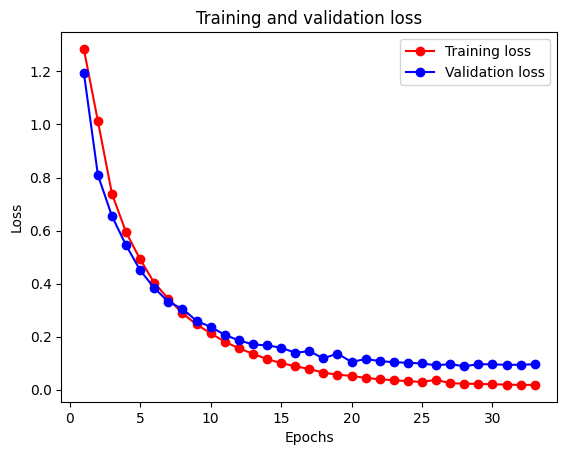

In [43]:
epochs = range(1, len(loss_rnn1)+1)
plt.clf()
plt.plot(epochs, loss_rnn1, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_rnn1, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

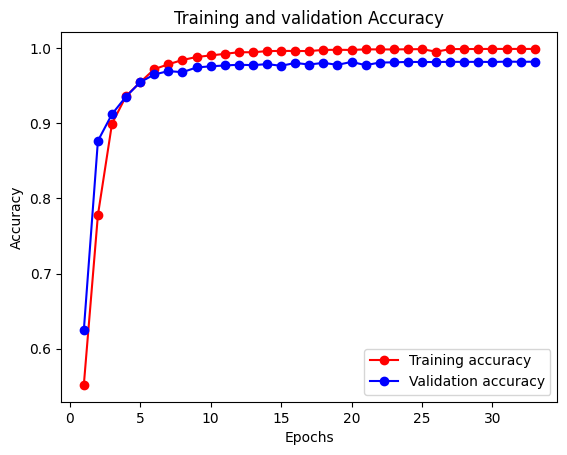

In [44]:
epochs = range(1, len(loss_rnn1)+1)
plt.clf()
plt.plot(epochs, acc_rnn1, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_rnn1, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
y_pred = model_rnn1.predict(x_test)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
confusion = confusion_matrix(Y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 2s 5ms/step
Accuracy: 0.9436525612472161
Precision: 0.9432501479154096
Recall: 0.9439947692287334
F1 score: 0.9435394137854646
Confusion matrix:
 [[4438  295]
 [ 211 4036]]


# Naive Bayes Model

In [46]:
# import necessary libraries
from sklearn.naive_bayes import GaussianNB
# create a Gaussian Naive Bayes model
nb_model = GaussianNB()
# fit the model to the training data
nb_model.fit(x_train, Y_train)
# make predictions on the test data
y_pred = nb_model.predict(x_test)
# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.5695991091314031
Precision: 0.5781636787406783
Recall: 0.5752435780596746
F1 score: 0.5672828766526985
Confusion matrix:
 [[2229 2504]
 [1361 2886]]


# Decision Tree Model and Random Forest Model

In [47]:
from sklearn.tree import DecisionTreeClassifier
# create a decision tree classifier
DT_model = DecisionTreeClassifier()
# fit the model to the training data
DT_model.fit(x_train, Y_train)
# make predictions on the test data
y_pred = DT_model.predict(x_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

Accuracy: 0.9329621380846325
Precision: 0.9326584260864701
Recall: 0.9329344520343738
F1 score: 0.9327873025895257
Confusion matrix:
 [[4418  315]
 [ 287 3960]]


In [48]:
from sklearn.ensemble import RandomForestClassifier
# create a random forest classifier
RF_model = RandomForestClassifier(n_estimators=100)
# fit the model to the training data
RF_model.fit(x_train, Y_train)
# make predictions on the test data
y_pred = RF_model.predict(x_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

<ipython-input-48-ef18587b97c2>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(x_train, Y_train)


Accuracy: 0.8968819599109131
Precision: 0.8966164613804745
Recall: 0.8965185949729693
F1 score: 0.8965664069271306
Confusion matrix:
 [[4275  458]
 [ 468 3779]]
